In [163]:
using Revise
using BilevelTrajOpt

using ForwardDiff
using DiffResults
using RigidBodyDynamics
using MeshCatMechanisms
using Plots
using Interpolations
using Profile
using ProfileView

In [2]:
urdf = joinpath("..", "urdf", "panda", "panda_arm.urdf")
mechanism = parse_urdf(Float64, urdf)
env = parse_contacts(mechanism, urdf, [])
x0 = MechanismState(mechanism);

In [ ]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf))
open(mvis)
# IJuliaCell(mvis)

In [3]:
# simple trajopt without the box to get a trajectory to simulate

Δt = 0.02
N = 50
traj_data = get_traj_data(mechanism,env,Δt,N,false)

x_start = zeros(traj_data.num_q+traj_data.num_v)
x_goal = zeros(traj_data.num_q+traj_data.num_v)

x_start[2] = .3
x_start[4] = -2.75
x_start[6] = -1.65

x_goal[2] = .8
x_goal[4] = -1.67
x_goal[6] = -2.2

add_state_eq!(traj_data, xi -> xi - x_start, 1)
add_state_eq!(traj_data, xi -> xi - x_goal, N)
add_fn_ineq!(traj_data, xi -> -pi - xi[4], Int(N/2))

traj = BilevelTrajOpt.trajopt_snopt(traj_data)

traj_t = vcat(0.,cumsum([Δt for i in 1:N-1]));
traj_q = [traj[1:num_positions(mechanism),i] for i in 1:N]
traj_u = traj[traj_data.num_q+traj_data.num_v+1:traj_data.num_q+2*traj_data.num_v,:]
ctrl_itp = Vector()
for i = 1:traj_data.num_v
   push!(ctrl_itp, Interpolations.CubicSplineInterpolation(0.:Δt:(N-1)*Δt,traj_u[i,:],extrapolation_bc=0.))
end
traj_itp = Vector()
for i = 1:traj_data.num_q+traj_data.num_v
    push!(traj_itp, Interpolations.CubicSplineInterpolation(0.:Δt:(N-1)*Δt,traj[i,:],extrapolation_bc=traj[i,end]))
end

┌ Warning: `a::Number + b::AbstractArray` is deprecated, use `a .+ b` instead.
│   caller = +(::Int64, ::Int64, ::UnitRange{Int64}) at operators.jl:502
└ @ Base ./operators.jl:502


Finished successfully: optimality conditions satisfied


In [ ]:
setanimation!(mvis, traj_t, traj_q)

In [ ]:
# package the resulting controller in a ctrl function to test (optional)
# urdf = joinpath("..", "urdf", "panda", "panda_arm.urdf")
# mechanism = parse_urdf(Float64, urdf)

Δt = 0.02
N = 100
sim_data = get_sim_data(mechanism,env,Δt,false)

function feedforward_ctrl!(u,t,x)
    u[:] = map(ctrl_itp) do itp
       itp(t) 
    end
end
function feedback_ctrl!(u,t,x)
    Kp = 250.
    Kd = 5.
    q = configuration(x)
    v = velocity(x)
    for i = 1:length(u)
       u[i] = ctrl_itp[i](t) + Kd*(traj_itp[traj_data.num_q+i](t)-v[i]) + Kp*(traj_itp[i](t)-q[i]) 
    end
end

set_configuration!(x0,x_start[1:traj_data.num_q])
set_velocity!(x0,x_start[sim_data.num_q+1:sim_data.num_q+sim_data.num_v])
setdirty!(x0)

traj_sim = BilevelTrajOpt.simulate_snopt(sim_data,feedback_ctrl!,x0,N-1)
traj_t_sim = vcat(0.,cumsum([Δt for i in 1:N-1]));
traj_q_sim = [traj_sim[1:num_positions(mechanism),i] for i in 1:N];

In [ ]:
setanimation!(mvis, traj_t_sim, traj_q_sim)

In [145]:
# simulating the panda arm pushing the box with the controller

urdf = joinpath("..", "urdf", "panda", "panda_arm_box.urdf")
mechanism = parse_urdf(Float64, urdf)

box_body = findbody(mechanism, "box")
basejoint = joint_to_parent(box_body, mechanism)
floatingjoint = Joint(basejoint.name, frame_before(basejoint), frame_after(basejoint), QuaternionFloating{Float64}())
replace_joint!(mechanism, basejoint, floatingjoint)
position_bounds(floatingjoint) .= RigidBodyDynamics.Bounds(-100, 100)
velocity_bounds(floatingjoint) .= RigidBodyDynamics.Bounds(-100, 100)

# adding surfaces
# Floor
μ = .31
# μ = .42
# μ = .68
motion_type = :xyz
floor_body = findbody(mechanism, "floor")
point = Point3D(default_frame(floor_body), [0.,0.,0.])
normal = FreeVector3D(default_frame(floor_body), [0.,0.,1.])
hs = HalfSpace(point, normal)
floor = Obstacle(hs, μ, motion_type, floor_body)

# Box (right now torque on the plane is ignored)
μ = 0.05
motion_type = :xyz
box_body = findbody(mechanism, "box")
point = Point3D(default_frame(box_body), [-.25,0.,.25])
normal = FreeVector3D(default_frame(box_body), [-1.,0.,0.])
hs = HalfSpace(point, normal)
box = Obstacle(hs, μ, motion_type, box_body, is_floating=true)

# obstacles = [floor]
obstacles = [floor,box]

env = parse_contacts(mechanism, urdf, obstacles)
Δt = 0.02
x0 = MechanismState(mechanism)
sim_data = get_sim_data(mechanism,env,Δt,false)

function feedback_ctrl_with_box!(u,t,x)
    u[:] .= 0.
    
    Kp = 250.
    Kd = 5.
    
    # todo use naming of states instead of assuming order
    q = configuration(x)[8:end]
    v = velocity(x)[7:end]
    for i = 1:length(u[7:end])
       u[6+i] = ctrl_itp[i](t) + Kd*(traj_itp[7+i](t)-v[i]) + Kp*(traj_itp[i](t)-q[i]) 
    end
end

feedback_ctrl_with_box! (generic function with 1 method)

In [ ]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf))
open(mvis)
# IJuliaCell(mvis)

In [146]:
N = 100

x_start = zeros(sim_data.num_q+sim_data.num_v)

# box
x_start[1] = 1.
x_start[5] = .8
x_start[7] = .275

# arm
x_start[7+2] = .3
x_start[7+4] = -2.75
x_start[7+6] = -1.65

set_configuration!(x0,x_start[1:sim_data.num_q])
set_velocity!(x0,x_start[sim_data.num_q+1:sim_data.num_q+sim_data.num_v])
setdirty!(x0)

sim_traj = BilevelTrajOpt.simulate_snopt(sim_data,feedback_ctrl_with_box!,x0,N-1)
sim_traj_t = vcat(0.,cumsum([Δt for i in 1:N-1]));
sim_traj_q = [sim_traj[1:num_positions(mechanism),i] for i in 1:N];
sim_traj_u = zeros(sim_data.num_v,N)
for i=1:N
    set_configuration!(x0,sim_traj[1:sim_data.num_q,i])
    set_velocity!(x0,sim_traj[sim_data.num_q+1:sim_data.num_q+sim_data.num_v,i])
    setdirty!(x0)
    t = sim_traj_t[i]
    u = zeros(sim_data.num_v)
    feedback_ctrl_with_box!(u,t,x0)
    sim_traj_u[:,i] = u[:]
end

Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished successfully: optimality conditions satisfied
Finished s

In [ ]:
setanimation!(mvis, sim_traj_t, sim_traj_q)

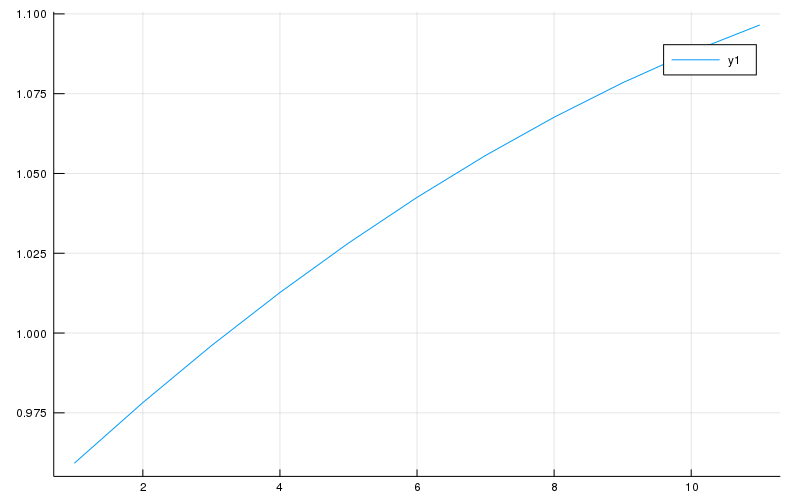

In [147]:
gr(size=(800,500), html_output_format=:png);
first_sample = 50
last_sample = 60
plot(sim_traj[5,first_sample:last_sample])

In [ ]:
# (optional) adding some noise - none in the results reported
q_noise_stddev = .001*(maximum(abs.(sim_traj[1:sim_data.num_q,:])))
v_noise_stddev = .001*(maximum(abs.(sim_traj[sim_data.num_q+1:sim_data.num_q+sim_data.num_v,:])))
sim_traj[1:sim_data.num_q,:] += randn(sim_data.num_q,N)*q_noise_stddev
sim_traj[sim_data.num_q+1:sim_data.num_q+sim_data.num_v,:] += randn(sim_data.num_v,N)*v_noise_stddev

In [156]:
# regressing the parameters of that simulation back (friction)

# portion of the traj we will use for parameter regression
regression_indx_raw = collect(first_sample:last_sample)

# pre-computing some of the transforms needed for the regression
regression_indx = []
contact_params = []
for i = 1:length(regression_indx_raw)
    q0 = sim_traj[1:sim_data.num_q,regression_indx_raw[i]]
    v0 = sim_traj[sim_data.num_q+1:sim_data.num_q+sim_data.num_v,regression_indx_raw[i]]
    u0 = sim_traj_u[:,regression_indx_raw[i]]
    qnext = sim_traj[1:sim_data.num_q,regression_indx_raw[i]+1]
    vnext = sim_traj[sim_data.num_q+1:sim_data.num_q+sim_data.num_v,regression_indx_raw[i]+1]
    cp = compute_contact_params(sim_data,q0,v0,u0,qnext,vnext)
    # only use datapoints where the contact points were active
    if all(cp.ϕs[1:4] .< 1e-8)
        push!(regression_indx, regression_indx_raw[i])
        push!(contact_params, cp)
    end
end
l_contact_params = length(contact_params)

function friction_loss_bilevel(μs)
    sim_data.μs[1:5] .= μs[1]
    
    loss = 0.
    for i = 1:l_contact_params
        cp = contact_params[i]
        x, λ, μ = solve_implicit_contact_τ(sim_data,cp.ϕs,cp.Dtv,
                                           cp.rel_transforms,cp.geo_jacobians,cp.geo_jacobians_surfaces,
                                           cp.HΔv,cp.bias,cp.contact_x0,cp.contact_λ0,cp.contact_μ0,
                                           ip_method=false,in_place=false,comp_scale=1000.,num_fosteps=1,num_sosteps=3)
        d = dynamics_contact_constraints(x,cp.rel_transforms,cp.geo_jacobians,cp.geo_jacobians_surfaces,
                                         cp.HΔv,cp.bias,sim_data)
        loss += (d[1:6]'*d[1:6])/l_contact_params
    end
    
    loss
end

fric_res = DiffResults.GradientResult(zeros(1))
function friction_fn_bilevel(μs)
    ForwardDiff.gradient!(fric_res, friction_loss_bilevel, μs)
    J = DiffResults.value(fric_res)
    gJ = DiffResults.gradient(fric_res)
    c = []
    gc = []
    fail = false
    J, c, gJ, gc, fail
end

μs0 = [1.]
lb = zeros(length(μs0))
ub = ones(length(μs0))
options = Dict{String, Any}()
options["Derivative option"] = 1
options["Verify level"] = -1
options["Major optimality tolerance"] = 1e-6

# call it once to compile
friction_fn_bilevel(μs0)

@time μsopt, fopt, info = snopt(friction_fn_bilevel, μs0, lb, ub, options, num_ineq=0, num_eq=0)

display(info)
display(μsopt)

"Finished successfully: optimality conditions satisfied"

1-element Array{Float64,1}:
 0.31000657958770916

 72.385936 seconds (499.60 M allocations: 26.460 GiB, 21.92% gc time)


In [181]:
@time μsopt, fopt, info = snopt(friction_fn_bilevel, μs0, lb, ub, options, num_ineq=0, num_eq=0)

 10.353062 seconds (71.31 M allocations: 3.777 GiB, 23.98% gc time)


([0.310007], 3.1962555352346105e-8, "Finished successfully: optimality conditions satisfied")

In [177]:
Profile.clear()
@profile μsopt, fopt, info = snopt(friction_fn_bilevel, μs0, lb, ub, options, num_ineq=0, num_eq=0)

┌ Warning: Deprecated syntax `implicit assignment to global variable `μsopt``.
│ Use `global μsopt` instead.
└ @ nothing none:0
┌ Warning: Deprecated syntax `implicit assignment to global variable `fopt``.
│ Use `global fopt` instead.
└ @ nothing none:0
┌ Warning: Deprecated syntax `implicit assignment to global variable `info``.
│ Use `global info` instead.
└ @ nothing none:0


InterruptException: InterruptException:

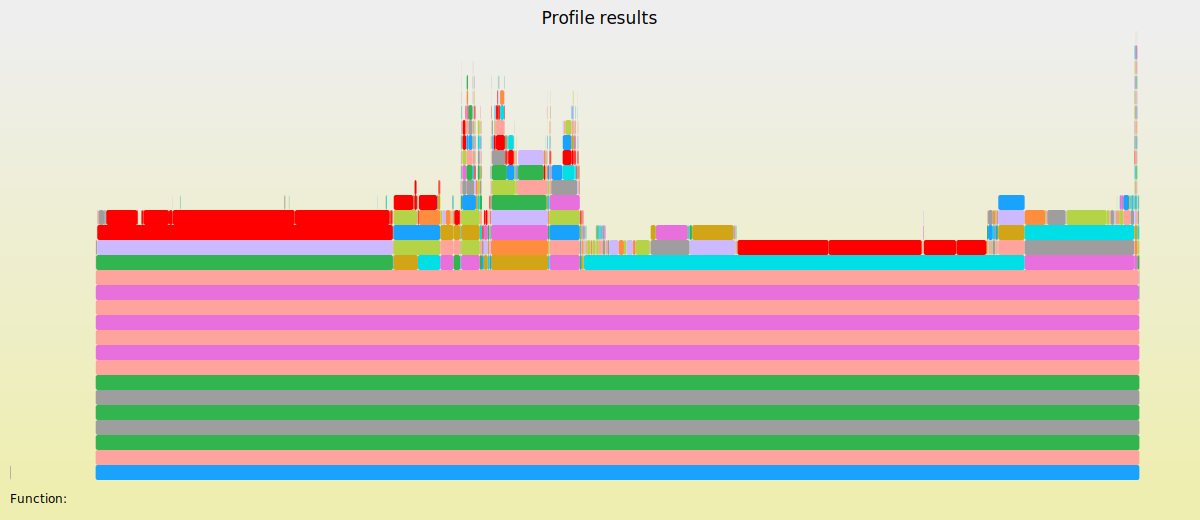

In [175]:
ProfileView.view()

In [150]:
# regressing with a single large NLP for comparison on time efficiency

# portion of the traj we will use for parameter regression
regression_indx_raw = collect(first_sample:last_sample)

# pre-computing some of the transforms needed for the regression
regression_indx = []
contact_params = []
for i = 1:length(regression_indx_raw)
    q0 = sim_traj[1:sim_data.num_q,regression_indx_raw[i]]
    v0 = sim_traj[sim_data.num_q+1:sim_data.num_q+sim_data.num_v,regression_indx_raw[i]]
    u0 = sim_traj_u[:,regression_indx_raw[i]]
    qnext = sim_traj[1:sim_data.num_q,regression_indx_raw[i]+1]
    vnext = sim_traj[sim_data.num_q+1:sim_data.num_q+sim_data.num_v,regression_indx_raw[i]+1]
    cp = compute_contact_params(sim_data,q0,v0,u0,qnext,vnext)
    # only use datapoints where the contact points were active
    if all(cp.ϕs[1:4] .< 1e-8)
        push!(regression_indx, regression_indx_raw[i])
        push!(contact_params, cp)
    end
end
l_contact_params = length(contact_params)

num_dyn = sim_data.num_v
num_comp = sim_data.num_contacts*(2+sim_data.β_dim)
num_pos = sim_data.num_contacts*(1+sim_data.β_dim) + 2*sim_data.num_contacts*(2+sim_data.β_dim)
function friction_loss(μsx::AbstractArray{T}) where T
    sim_data.μs[1:5] .= μsx[1]
    xall = reshape(μsx[2:end],sim_data.num_contacts*(2+sim_data.β_dim),l_contact_params)
    eq_con = zeros(T,l_contact_params*(num_comp+num_dyn))
    ineq_con = zeros(T,l_contact_params*num_pos)
    
    J = 0.
    for i = 1:l_contact_params
        cp = contact_params[i]
        x̃ = xall[:,i]
        d = BilevelTrajOpt.dynamics_contact_constraints(x̃,cp.rel_transforms,cp.geo_jacobians,cp.geo_jacobians_surfaces,cp.HΔv,cp.bias,sim_data)
        c = 1000. * BilevelTrajOpt.complementarity_contact_constraints(x̃,cp.ϕs,cp.Dtv,sim_data)
        p = BilevelTrajOpt.pos_contact_constraints(x̃,cp.Dtv,sim_data)
    
        J += (d[1:6]'*d[1:6])/l_contact_params
        eq_con[(i-1)*(num_comp+num_dyn)+1:i*(num_comp+num_dyn)] = vcat(c,d)
        ineq_con[(i-1)*num_pos+1:i*num_pos] = p
    end
    
    vcat(J,eq_con,ineq_con)
end

μxtmp = zeros(1+sim_data.num_contacts*(2+sim_data.β_dim)*l_contact_params)
fric_res = DiffResults.JacobianResult(friction_loss(μxtmp),μxtmp)
function friction_fn(μsx)
    ForwardDiff.jacobian!(fric_res, friction_loss, μsx)
    val = DiffResults.value(fric_res)
    grad = DiffResults.gradient(fric_res)
    
    J = val[1]
    c_eq = val[1+1:1+l_contact_params*(num_comp+num_dyn)]
    c_ineq = val[1+l_contact_params*(num_comp+num_dyn)+1:1+l_contact_params*(num_comp+num_dyn)+l_contact_params*num_pos]
    
    gJ = grad[1,:]
    gc_eq = grad[1+1:1+l_contact_params*(num_comp+num_dyn),:]
    gc_ineq = grad[1+l_contact_params*(num_comp+num_dyn)+1:1+l_contact_params*(num_comp+num_dyn)+l_contact_params*num_pos,:]
    
    fail = false
    
    J, c_ineq, c_eq, gJ, gc_ineq, gc_eq, fail
end

μsx0 = vcat(1.,zeros(sim_data.num_contacts*(2+sim_data.β_dim)*l_contact_params))
lb = zeros(length(μsx0))
ub = 100. * ones(length(μsx0))
ub[1] = 1.
options = Dict{String, Any}()
options["Derivative option"] = 1
options["Verify level"] = -1
options["Major optimality tolerance"] = 1e-6
options["Iterations limit"] = 50000
options["Major iterations limit"] = 10000

# call it once to compile
friction_fn(μsx0)

@time μsxopt, fopt, info = snopt(friction_fn, μsx0, lb, ub, options)

display(info)
display(μsxopt)

"Terminated after numerical difficulties: current point cannot be improved"

289-element Array{Float64,1}:
  0.30999999999995964   
  0.0                   
  1.110032387441601e-16 
  0.0557332876414417    
  1.1102230193543035e-16
  0.9503491645316713    
  0.1797847988433846    
  0.0                   
  1.3990223912256121e-16
  1.4566588325959765e-7 
  5.784433883513187e-17 
  0.9502579336454019    
  4.698899468286725e-7  
  ⋮                     
  2.2204460455188117e-16
  9.683180907741939e-17 
  1.0375008877051861e-16
  1.372482074342472e-16 
  0.704508289426274     
  2.404885333167186e-15 
  3.7423755315232345e-14
 -3.820806792448779e-14 
  1.1101928468670952e-16
  3.357351650569644e-16 
  0.3451524158833263    
  0.0                   

 12.007104 seconds (159.32 M allocations: 6.875 GiB, 21.31% gc time)


In [151]:
@time μsxopt, fopt, info = snopt(friction_fn, μsx0, lb, ub, options)

  2.059815 seconds (25.44 M allocations: 1.185 GiB, 28.62% gc time)


([0.31, 0.0, 1.11003e-16, 0.0557331, 1.11022e-16, 0.950349, 0.179784, 0.0, 1.39902e-16, 2.921e-7  …  1.0375e-16, 1.37248e-16, 0.0921245, -2.40489e-15, -3.96376e-14, 6.72062e-16, 1.11019e-16, 3.35735e-16, 0.342186, 0.0], 8.192363379765964e-22, "Terminated after numerical difficulties: current point cannot be improved")

In [ ]:
# regressing a simple ball simulation with one point of contact (toy example to debug as needed)

urdf = joinpath("..", "urdf", "ball.urdf")
mechanism = parse_urdf(Float64, urdf)
body = findbody(mechanism, "ball")
basejoint = joint_to_parent(body, mechanism)
floatingjoint = Joint(basejoint.name, frame_before(basejoint), frame_after(basejoint), QuaternionFloating{Float64}())
replace_joint!(mechanism, basejoint, floatingjoint)
position_bounds(floatingjoint) .= RigidBodyDynamics.Bounds(-100, 100)
velocity_bounds(floatingjoint) .= RigidBodyDynamics.Bounds(-100, 100)
μ = 0.34
motion_type = :xyz 
floor_body = findbody(mechanism, "floor")
point = Point3D(default_frame(floor_body), [0.,0.,0.])
normal = FreeVector3D(default_frame(floor_body), [0.,0.,1.])
hs = HalfSpace(point, normal)
floor = Obstacle(hs, μ, motion_type, floor_body)
obstacles = [floor]
env = parse_contacts(mechanism, urdf, obstacles)
x0 = MechanismState(mechanism)
Δt = 0.005
sim_data = get_sim_data(mechanism,env,Δt,false);

N = 100
q0 = [1., 0., 0., 0., 0., 0., 0.]
v0 = [0., 0., 0., 5., 0., 0.]

u0 = zeros(sim_data.num_v)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
ctrl! = (u,t,x) -> u[:] .= 0.
traj = BilevelTrajOpt.simulate_snopt(sim_data,ctrl!,x0,N);

In [ ]:
function friction_loss_toy(μs)
    sim_data.μs[:] = μs[:]
    
    loss = 0.
    for i = 1:N-1
        q0 = traj[1:sim_data.num_q,i]
        v0 = traj[sim_data.num_q+1:sim_data.num_q+sim_data.num_v,i]
        qnext = traj[1:sim_data.num_q,i+1]
        vnext = traj[sim_data.num_q+1:sim_data.num_q+sim_data.num_v,i+1]
        τ, x, d = solve_implicit_contact_τ(sim_data,q0,v0,u0,qnext,vnext,ip_method=false,in_place=true) 
        loss += d'*d 
    end
    
    loss
end

fric_res = DiffResults.GradientResult(zeros(sim_data.num_contacts))
function friction_fn_toy(μs)
    ForwardDiff.gradient!(fric_res, friction_loss_toy, μs)
    J = DiffResults.value(fric_res)
    gJ = DiffResults.gradient(fric_res)
    
    c = []
    gc = []
    
    fail = false
    
    J, c, gJ, gc, fail
end

μs0 = [1.]
lb = zeros(length(μs0))
ub = ones(length(μs0))
options = Dict{String, Any}()
options["Derivative option"] = 1
options["Verify level"] = -1
options["Major optimality tolerance"] = 1e-6

μsopt, fopt, info = snopt(friction_fn_toy, μs0, lb, ub, options)

display(info)
display(μsopt)